<a href="https://colab.research.google.com/github/jblanco89/MonteCarloSimulator/blob/master/StocksData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Data Processing for Montecarlo Simulation
## Coingecko API Connection

In [1]:
# Install coingecko client
# more information check: https://github.com/man-c/pycoingecko
!pip install pycoingecko

In [2]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pycoingecko import  CoinGeckoAPI

# var API client
cg = CoinGeckoAPI()

### Let's create a coin symbol list from coingecko

In [3]:
coin_list = cg.get_coins_list()
coin_list_df = pd.DataFrame(coin_list)
coin_list_df.head()

,id,symbol,name
0,01coin,zoc,01coin
1,0-5x-long-algorand-token,algohalf,0.5X Long Algorand Token
2,0-5x-long-altcoin-index-token,althalf,0.5X Long Altcoin Index Token
3,0-5x-long-balancer-token,balhalf,0.5X Long Balancer Token
4,0-5x-long-bitcoin-cash-token,bchhalf,0.5X Long Bitcoin Cash Token


In [4]:
coin_list_df.to_excel('coin_list.xlsx')

In [5]:
coin_list_df.shape

(9610, 3)

In [6]:
#we try how it is working
#we get coin id from 'symbol';
stock_id = coin_list_df[coin_list_df.symbol.isin(['uni'])]
stock_id.iloc[0,0]

'unicorn-token'

### Delete information about repeated ID, for instance: ADA has two ID: 'binace-peg-cardano' and 'cardano'; the second one is desired

In [7]:
unwanted_ID_list = ['binance-peg-cardano', 'binance-peg-litecoin', 'binance-peg-avalanche','binance-peg-xrp', 'unicorn-token']
coin_df = coin_list_df[~coin_list_df.id.isin(unwanted_ID_list)]
coin_df.shape

(9605, 3)

In [8]:
#We try again and it works
stock_id = coin_df[coin_df.symbol.isin(['uni'])]
stock_id.iloc[0,0]

'uniswap'

In [9]:
#get id function

def get_id(symbs):
  stock_id = []
  for s in symbs:
    stock_id.append(coin_df[coin_df.symbol.isin([s])].iloc[0,0])
  return stock_id

#date time format transformation
#from normal time to UNIX format

def timetoUnix(start_date, end_date):
  date_obj_1 = datetime.strptime(start_date, '%m/%d/%y')
  date_obj_2 = datetime.strptime(end_date, '%m/%d/%y')

  range_1 = (date_obj_1 - datetime(1970,1,1)).total_seconds()
  range_2 = (date_obj_2 - datetime(1970,1,1)).total_seconds()
  return range_1, range_2




# Get stock data for analysis
### We define symbol list related our desired portfolio

In [10]:
#We get id's from symbol list defined by user
symbs = ['ltc', 'sol', 'cake', 'ray', 'ada', 'crv', 'AVAX', 'bnb', 'uni']
id_data = get_id(symbs=symbs)


In [11]:
id_data

['litecoin',
 'solana',
 'pancakeswap-token',
 'raydium',
 'cardano',
 'curve-dao-token',
 'avalanche-2',
 'binancecoin',
 'uniswap']

In [12]:
date_1 = '04/01/21'
date_2 = '10/09/21'

t= timetoUnix(date_1,date_2)


In [13]:
#we get stock data in daily interval
data = []
for id in id_data:
  data.append(cg.get_coin_market_chart_range_by_id(id, 'usd', t[0], t[1]))



In [14]:
#Because we have a nested list of prices, it is necessary flatten it up
pr={}
for i in range(0,len(id_data)):
  pr[i] = sum(data[i]['prices'], [])

  

In [15]:
#we just need to get prices and dates which they will be stored separately
prices = []
dates = []
for coin in range(0,len(id_data)):
  for price in pr[coin][1::2]:
    prices.append(price)
  
for date in pr[0][::2]:
  date = (int(date)/1000)
  e = (datetime.utcfromtimestamp(date).strftime('%m/%d/%y %H:%M:%S'))
  dates.append(e)


In [16]:
#we need to split data by specific amount of rows (days, minutes, months, etc.)
partition = int(len(prices) / len(symbs)) + 1
partition


193

In [17]:
len(prices)

1728

In [18]:
#we define a function to split list
def slice_per(source, step):
    return [source[i::step] for i in range(step)]

In [19]:
data_pr = slice_per(prices,partition)

In [20]:
#I need fix this data frame

pr_df = pd.DataFrame(data_pr, columns=symbs).dropna(axis=0)
pr_df.tail()

,ltc,sol,cake,ray,ada,crv,AVAX,bnb,uni
179,150.656073,136.259521,18.043724,9.162281,2.116652,2.531656,69.483935,431.449016,25.301983
180,145.060855,130.604892,18.506999,9.623827,2.246769,2.551069,68.971326,427.545862,25.681384
181,140.406125,135.279163,18.884835,10.980628,2.247219,2.825936,65.253818,443.435448,25.320647
182,145.033389,141.183746,19.936825,11.206057,2.258839,2.873139,64.726431,435.262006,25.589763
183,153.145376,161.374029,20.112291,11.540420,2.195095,2.930080,60.124740,439.932647,24.716686


In [21]:
pr_df.shape

(184, 9)

In [22]:
dates_df = pd.DataFrame(dates, columns=['Timestamp']).dropna(axis=0)
dates_df.tail()

,Timestamp
187,10/05/21 00:00:00
188,10/06/21 00:00:00
189,10/07/21 00:00:00
190,10/08/21 00:00:00
191,10/09/21 00:00:00


In [23]:
pr_df.shape


(184, 9)

In [24]:
dates_df.shape

(192, 1)

In [25]:
pr_df = pr_df.reset_index(drop=True)
dates_df = dates_df.reset_index(drop=True)

In [26]:
df_final = pd.concat([dates_df, pr_df], axis=1).dropna(axis=0)
df_final.tail()

,Timestamp,ltc,sol,cake,ray,ada,crv,AVAX,bnb,uni
179,09/27/21 00:00:00,150.656073,136.259521,18.043724,9.162281,2.116652,2.531656,69.483935,431.449016,25.301983
180,09/28/21 00:00:00,145.060855,130.604892,18.506999,9.623827,2.246769,2.551069,68.971326,427.545862,25.681384
181,09/29/21 00:00:00,140.406125,135.279163,18.884835,10.980628,2.247219,2.825936,65.253818,443.435448,25.320647
182,09/30/21 00:00:00,145.033389,141.183746,19.936825,11.206057,2.258839,2.873139,64.726431,435.262006,25.589763
183,10/01/21 00:00:00,153.145376,161.374029,20.112291,11.540420,2.195095,2.930080,60.124740,439.932647,24.716686


In [27]:
df_mean_values = df_final.mean()
df_mean_values.mean()


83.16591838679723

In [28]:
y1=[]
y2 = []
for v in range(len(df_mean_values)):
  if round(df_mean_values[v], 0) >= df_mean_values.median():
    y1.append(df_mean_values.index[v])
  else:
    y2.append(df_mean_values.index[v])

In [29]:
y1

['ltc', 'sol', 'AVAX', 'bnb']

In [30]:
def plot_stock_data():
  ax = df_final.plot(x='Timestamp', y=y1, figsize=(15,10))
  ax2 = df_final.plot(x='Timestamp', y=y2,secondary_y=True, ax=ax)
  ax.grid(False, color='k', linestyle='-', linewidth=0.5)
  ax.set_facecolor('1')
  ax.set_ylabel('USD')
  ax2.set_ylabel('USD')
  ax.tick_params(labelsize = 14, axis='x', labelrotation=45)
  ax.tick_params(labelsize = 14)
  ax2.tick_params(labelsize = 14)
  plt.title('Crypto Portfolio graph',fontdict={ 
      'fontsize':22, 
      'fontweight':'bold', 
      'color': 'k'}, loc='center')
  return plt.show()


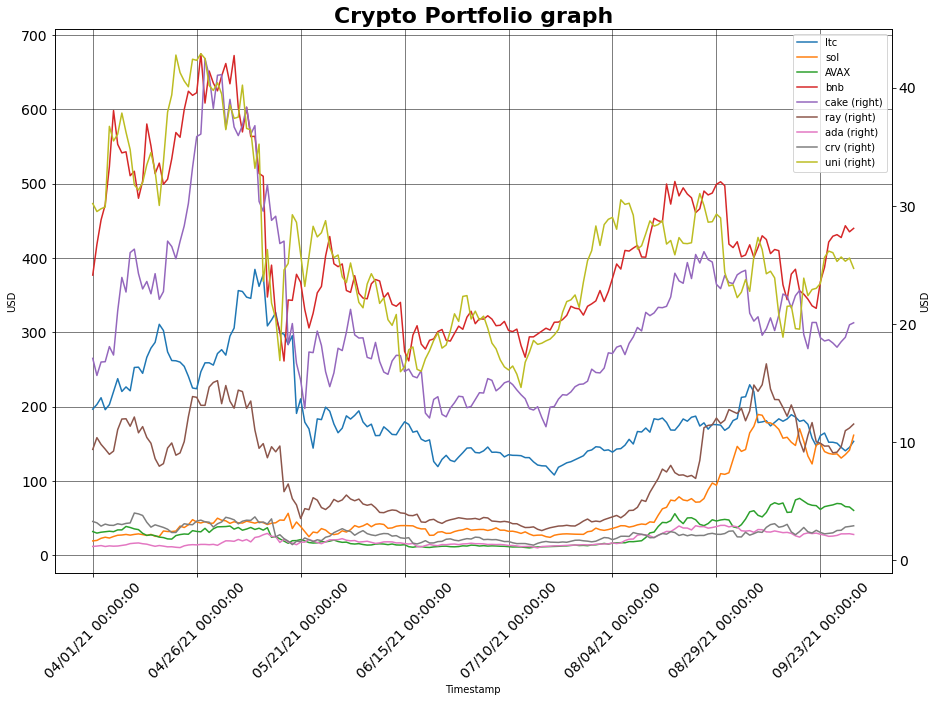

In [31]:
plot_stock_data()